# Analyze VLF data during LAMP launch 
Data from AARDDVARK database:
https://psddb.nerc-bas.ac.uk/data/access/plots.php?class=232&day=64&graph=main&menu=4,7&month=03&site=Fairbanks&type=ULTRA&year=2022


By Jodie McLennan,  Feb 2024

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from scipy.optimize import curve_fit
#testing

In [43]:
# load in data from the Fairbanks VLF receiver for 2022-03-05
#dir = '/Users/jmcle/OneDrive/Documents/Aurora Research/Fairbanks VLF data/VLF_2022_03_05/data/psddata/atmos/space/vlf/ultra/fairbanks/_/2022/data/'
#dir = '/Users/jmclnnan/OneDrive - University of Iowa/Documents/GitHub/VLF_project/Fairbanks VLF data/VLF_2022_03_05/data/psddata/atmos/space/vlf/ultra/fairbanks/_/2022/data/'

# switch dir_main based on system working from
dir_main = '/Users/jmclnnan/OneDrive - University of Iowa/Documents/GitHub/VLF_project/Fairbanks VLF data/'
dir_2 = 'VLF_2022_03_05/data/psddata/atmos/space/vlf/ultra/fairbanks/_/2022/data/'
dir = dir_main+dir_2

data_files = os.listdir(dir)
data_files = [f for f in data_files if f.endswith('.txt')]

datadict = {}
for file in data_files:
    print(file)
    database = np.loadtxt(dir+file, dtype=float, comments='%') #delimiter='\t'
    time = database[:,0] # in seconds
    amplitude = database[:,1]
    phase = database[:,2]
    path = file[:3]

    datadict[path] = {'time':time, 'amplitude':amplitude, 'phase':phase}


BAC20220305.txt
DHO20220305.txt
HWU20220305.txt
JXN20220305.txt
NAA20220305.txt
NDK20220305.txt
NLK20220305.txt
NPM20220305.txt
NRK20220305.txt


c:\Users\jmclnnan\Anaconda3\envs\pulsating_aurora\lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


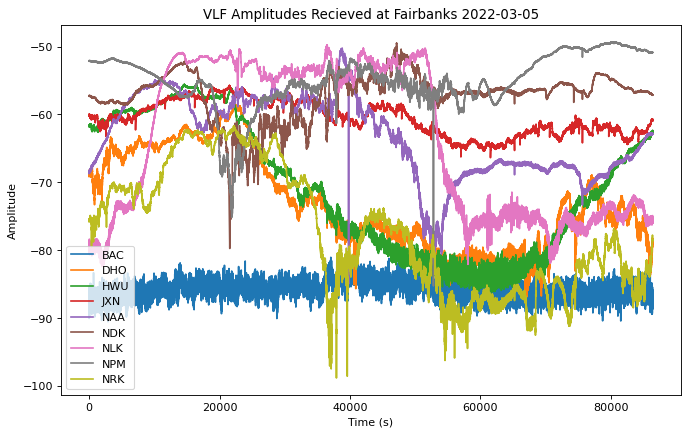

In [44]:
# Plot the data all together for VLF Fairbanks reciever 2022-03-05

plt.figure(figsize=(10,6),dpi=80)

for key in datadict.keys():
    time = datadict[key]['time']
    amplitude = datadict[key]['amplitude']
    plt.plot(time, amplitude, label=key)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('VLF Amplitudes Recieved at Fairbanks 2022-03-05')
plt.legend()

In [151]:
# Load in quiet times
# quiet times are stored in the same directory as the data files, but have to look for days that look relavitely flat

# dictionary for all the days that were determined as quiet (has some extra files)
quietdict = {}

years =['2022','2023']
paths = []
for year in years:
    # if day == '2022_03_02':
    #     dir = '/Users/jmcle/OneDrive/Documents/Aurora Research/Fairbanks VLF data/VLF_'+day+'/data/psddata/atmos/space/vlf/ultra/fairbanks/_/2022/data/'
    #dir = '/Users/jmcle/OneDrive/Documents/Aurora Research/Fairbanks VLF data/data/psddata/atmos/space/vlf/ultra/fairbanks/'+year+'/data/'
    
    dir_2 = '/data/psddata/atmos/space/vlf/ultra/fairbanks/'+year+'/data/'
    dir = dir_main + dir_2

    data_files = os.listdir(dir)
    data_files = [f for f in data_files if f.endswith('.txt')]

    for file in data_files:
        print(file)
        database = np.loadtxt(dir+file, dtype=float, comments='%') #delimiter='\t'
        time = database[:,0] # in seconds
        amplitude = database[:,1]
        phase = database[:,2]
        day = file[3:-4]
        path = file[:-4]
        paths.append(path)

        quietdict[path] = {'time':time, 'amplitude':amplitude, 'phase':phase}




BAC20220228.txt
BAC20220301.txt
BAC20220309.txt
NAA20220228.txt
NAA20220301.txt
NAA20220302.txt
NAA20220303.txt
NAA20220304.txt
NAA20220306.txt
NAA20220307.txt
NAA20220308.txt
NAA20220309.txt
NDK20220228.txt
NDK20220301.txt
NDK20220302.txt
NDK20220303.txt
NDK20220304.txt
NDK20220306.txt
NDK20220307.txt
NDK20220308.txt
NDK20220309.txt
NLK20220228.txt
NLK20220301.txt
NLK20220302.txt
NLK20220303.txt
NLK20220304.txt
NLK20220306.txt
NLK20220307.txt
NLK20220308.txt
NLK20220309.txt
NRK20220228.txt
NRK20220301.txt
NRK20220302.txt
NRK20220303.txt
NRK20220304.txt
NRK20220306.txt
NRK20220307.txt
NRK20220308.txt
NRK20220309.txt
NAA20230303.txt
NAA20230304.txt
NAA20230305.txt
NAA20230308.txt
NDK20230303.txt
NDK20230304.txt
NDK20230305.txt
NDK20230308.txt
NLK20230303.txt
NLK20230304.txt
NLK20230305.txt
NLK20230308.txt
NRK20230303.txt
NRK20230304.txt
NRK20230305.txt
NRK20230308.txt


In [159]:
## Average the quiet days
# path names to find a quiet curve fit 
pathnames = ['NLK','NDK','NAA','NRK']
# the quiet days for each path - following the order of pathnames
quietdays = [['20220301','20220302','20220309','20220228','20220303','20220308'],['20220303','20230304','20230303','20230305','20230308'],['20220306','20220302','20220303','20230304'],['20220303','20220308','20220302']]
#quietdays = [['20220303','20220302','20220306','20220307'],['20220303','20220302','20220306','20220307'],['20220303','20220302','20220306','20220307'],['20220303','20220302','20220306','20220307']]

# set the runnning average:
bintime = 15 #secs

# dictionary for quiet day curve fits
qdc_dict = {}

# flag path array for the quiet days 
quietdayflag = np.zeros(len(paths))

# loop through each path
for i,whichpath in enumerate(pathnames):
    
    avgamp = np.zeros(int(((time[-1])+1)/bintime)) # set up average per path

    # loop through each of the designated quiet days
    for qdays in quietdays[i]:

        # loop through all of the saved path data files
        for j,p in enumerate(paths):
            
            # if saved path/day data file matches a designated quiet day
            if p == whichpath+qdays:
                print(p)
                quietdayflag[j] = 1
                # set up the running average arrays
                binned_amp = []
                binned_time = []
                # get the data
                time = quietdict[p]['time']
                amp = quietdict[p]['amplitude']
                # set up runnign average values
                maxtime = time[-1]
                initialsec = time[0]
                multiples = int(round((maxtime-initialsec)/bintime)) # how many bins
                lenindex = len(time)
                indexblock = int(round(lenindex/multiples)) # how many indices in each bin
                # running average
                for m in np.arange(multiples):
                    if m==0:
                        run_amp = np.average(amp[0:((m+1)*indexblock)])
                        run_time = np.average(time[0:(m+1)*indexblock])
                    else:
                        run_amp = np.average(amp[m*indexblock:(m+1)*indexblock])
                        run_time = np.average(time[m*indexblock:(m+1)*indexblock])
                    binned_amp.append(run_amp)
                    binned_time.append(run_time)
    
                #print(len(binned_amp))
                # if len(binned_amp) != 8640:
                #     print('ERROR: ',p)
                    
                # add the running average to the path's average
                avgamp += binned_amp

    # average out each path's running average             
    avgamp = avgamp/len(quietdays[i])

    # save the running average to the dictionary
    qdc_dict[whichpath] = {'time':binned_time, 'amplitude':avgamp}



NLK20220301
NLK20220302
NLK20220309
NLK20220228
NLK20220303
NLK20220308
NDK20220303
NDK20230304
NDK20230303
NDK20230305
NDK20230308
NAA20220306
NAA20220302
NAA20220303
NAA20230304
NRK20220303
NRK20220308
NRK20220302


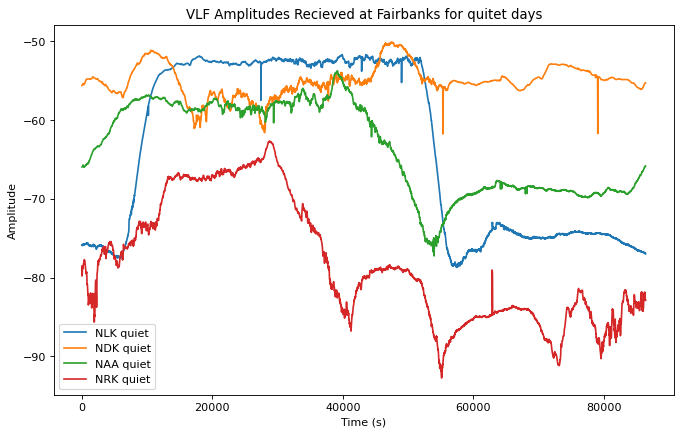

In [160]:
plt.figure(figsize=(10,6),dpi=80)
for qdc_dict_key in qdc_dict.keys():
    plt.plot(qdc_dict[qdc_dict_key]['time'], qdc_dict[qdc_dict_key]['amplitude'], label=qdc_dict_key+' quiet')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('VLF Amplitudes Recieved at Fairbanks for quitet days')
plt.legend()

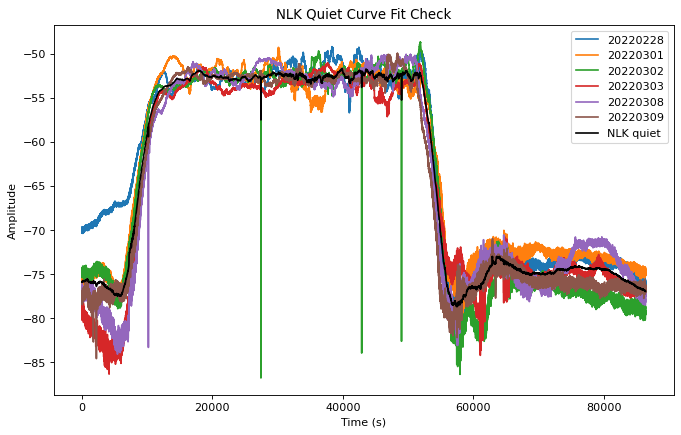

In [161]:
# check the fit of the quiet days
pathcheck = 'NLK'
plt.figure(figsize=(10,6),dpi=80)
for key in quietdict.keys():
    if key[:3] == pathcheck and quietdayflag[paths.index(key)] == 1:
        day = key[3:]
        time = quietdict[key]['time']
        amplitude = quietdict[key]['amplitude']
        plt.plot(time, amplitude, label=day)

plt.plot(qdc_dict[pathcheck]['time'], qdc_dict[pathcheck]['amplitude'],'k', label=pathcheck+' quiet')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude') 
plt.title(pathcheck+' Quiet Curve Fit Check')
plt.legend()



In [162]:
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.interpolate import splrep, BSpline


In [163]:
# Define curves to fit parts of the quiet days
def straightLine(x, a, b):
    return a*x + b

def expotential(x, a, b, c):
    return a * np.exp(b * x) + c

# define piecewise func for NLK
def NLK_qdc(x,break1, break2, break3, break4):
    # Quiet day curve for NLK path
    #INPUTS:
    # x = time array 
    # break1 = break point between functions
    # a, b, .. = coefficients to fit in scipy.optimize.curve_fit
    #OUTPUTS: 
    # return = amplitude values for curve

    # # set up runnign average values
    # bintime = 100
    # maxtime = x[-1]
    # initialsec = x[0]
    # multiples = int(round((maxtime-initialsec)/bintime)) # how many bins
    # lenindex = len(x)
    # indexblock = int(round(lenindex/multiples)) # how many indices in each bin

    # binned_amp = []
    # binned_time = []
    # # running average
    # for m in np.arange(multiples):
    #     if m==0:
    #         run_amp = np.average(amplitude[0:((m+1)*indexblock)])
    #         run_time = np.average(x[0:(m+1)*indexblock])
    #     else:
    #         run_amp = np.average(amplitude[m*indexblock:(m+1)*indexblock])
    #         run_time = np.average(x[m*indexblock:(m+1)*indexblock])
    #     binned_amp.append(run_amp)
    #     binned_time.append(run_time)

    # binned_amp = np.asarray(binned_amp)
    # binned_time = np.asarray(binned_time)
    
    y = np.zeros(len(x))

    ########### piece 1: (hline)
    piece1 = np.where(x<break1)
    # print(piece1)
    
    y[piece1] = np.mean(amplitude[piece1])


    ########### piece 2: (cublic spline -- update later)
    piece2 = np.where((x>break1) &(x<break2))
    #y[piece2] = straightLine(x[piece2],a2,b2)

    ## Cubic Spline
    # cs2 = CubicSpline(x[piece2],amplitude[piece2])
    # y[piece2] = cs2(x[piece2])

    tck_s2 = splrep(x[piece2], amplitude[piece2], s=15000)#int(len(x)/2))

    # slices_n = []
    # slices_n.append(np.argwhere((binned_time >= break1) 
    #                                 & (binned_time <= break2)))
    # # Flatten array indices
    # slices_n = [item[0] for sublist in slices_n for item in sublist]


    y[piece2] = BSpline(*tck_s2)(x[piece2])
    #y[piece2] = amplitude[piece2]

    ## polyfit
    # p2 = np.polyfit(x[piece2], amplitude[piece2],3)
    # poly2 = np.poly1d(p2)
    # y[piece2] = poly2(x[piece2])

    

    ########## piece 3: (hline)
    piece3 = np.where((x>break2) & (x<break3))
    y[piece3] = np.mean(amplitude[piece3])

    ######### piece 4: (cublic spline -- update later)
    piece4 = np.where((x>break3) & (x<break4))

    tck_s4 = splrep(x[piece4], amplitude[piece4], s= 15000) #int(len(x)/2))
    y[piece4] = BSpline(*tck_s4)(x[piece4])
    #y[piece4] = amplitude[piece4]

    #y[piece4] = straightLine(x[piece4],a4,b4)

    ## Cubic Spline
    # cs4 = CubicSpline(x[piece4],amplitude[piece4])
    #y[piece4] = cs4(x[piece4])

    ## polyfit
    # p4 = np.polyfit(x[piece4], amplitude[piece4],3)
    # poly4 = np.poly1d(p4)
    # y[piece4] = poly4(x[piece4])

    

    ######### piece 5: (hline)
    piece5 = np.where(x>break4)
    y[piece5] = np.mean(amplitude[piece5])
    

    return y

# version 2
def NLK_qdc_v2(x,break1, break2, break3, break4, a2, b2, a4, b4):
    # Quiet day curve for NLK path
    #INPUTS:
    # x = time array 
    # break1 = break point between functions
    # a, b, .. = coefficients to fit in scipy.optimize.curve_fit
    #OUTPUTS: 
    # return = amplitude values for curve

    print(x)
    # piece 1: (hline)
    if x< break1:
        piece1 = np.argwhere(x<break1)
    
        y= np.mean(amplitude[piece1])

    
    # piece 2: (cublic spline -- update later)
    elif x>break1 and x<break2:
        piece2 = np.argwhere(x>break1 and x<break2)
        y = straightLine(x[piece2],a2,b2)
        

    # piece 3: (hline)
    elif x>break2 and x<break3:   
        piece3 = np.where(x>break2 and x<break3)
        y = np.mean(amplitude[piece3])

    # piece 4: (cublic spline -- update later)
    elif x>break3 and x<break4:
        piece4 = np.argwhere(x>break3 and x<break4)
        y = straightLine(x[piece4],a4,b4)

    # piece 5: (hline)
    elif x>break4 :
        piece5 = np.argwhere(x>break4)
        y = np.mean(amplitude[piece5])
    
    else:
        y=0

    return y



In [164]:
# Running average function
def run_avg(time, amp, bintime):
    ## Function to find the running boxcar average of two arrays
    # INPUTS:
    # time: x values
    # amp: y values
    # bintime: the bin size (same units as time)
    # OUTPUTS:
    # binned_time: corresponding x values after running avg
    # binned_amp: y values after running avg

    # set up runnign average values
    maxtime = time[-1]
    initialsec = time[0]
    multiples = int(round((maxtime-initialsec)/bintime)) # how many bins
    lenindex = len(time)
    indexblock = int(round(lenindex/multiples)) # how many indices in each bin
    binned_time = []
    binned_amp = []

    print('2d: '+str(multiples))
    # running average
    for m in np.arange(multiples):
        if m==0:
            run_amp = np.average(amp[0:((m+1)*indexblock)])
            run_time = np.average(time[0:(m+1)*indexblock])
        else:
            run_amp = np.average(amp[m*indexblock:(m+1)*indexblock])
            run_time = np.average(time[m*indexblock:(m+1)*indexblock])
        binned_amp.append(run_amp)
        binned_time.append(run_time)
    
    return binned_time, binned_amp

def run_avg1d(time, bintime):
    ## Function to find the running boxcar average of an array 
    # INPUTS:
    # time: x values
    # bintime: the bin size (same units as time)
    # OUTPUTS:
    # binned_time: corresponding x values after running avg

    # set up runnign average values
    maxtime = time[-1]
    initialsec = time[0]
    multiples = int(round((maxtime-initialsec)/bintime)) # how many bins
    print('1d: '+str(multiples))
    
    lenindex = len(time)
    indexblock = int(round(lenindex/multiples)) # how many indices in each bin
    binned_time = []


    
    # running average
    for m in np.arange(multiples):
        if m==0:
            run_time = np.average(time[0:(m+1)*indexblock])
        else:
            run_time = np.average(time[m*indexblock:(m+1)*indexblock])
        binned_time.append(run_time)
   
    return binned_time

In [173]:
import datetime as dt
from datetime import timedelta
from matplotlib import dates as mdates
from matplotlib.ticker import MultipleLocator 
time_dt = [dt.datetime(2022,3,1,0,0,0)+i*timedelta(seconds=1) for i in np.arange(len(time))]
#print(time_dt)

Starting: 20220228
Curvefitting....
[ 4000.00005869 18000.000259   45000.0006765  62000.00090624]
2d: 86
Starting: 20220301
Curvefitting....
[ 4000.00005993 18000.00025857 45000.00066451 62000.00091562]
2d: 86
Starting: 20220302
Curvefitting....
[ 4000.00005985 18000.00026916 45000.00065566 62000.00093295]
2d: 86
Starting: 20220303
Curvefitting....
[ 4000.00006065 18000.00026821 45000.00069819 62000.0009    ]
2d: 86
Starting: 20220308
Curvefitting....
[ 4000.00006167 18000.00027233 45000.00065789 62000.00092205]
2d: 86
Starting: 20220309
Curvefitting....
[ 4000.00005973 18000.00026168 45000.00067772 62000.00091829]
2d: 86


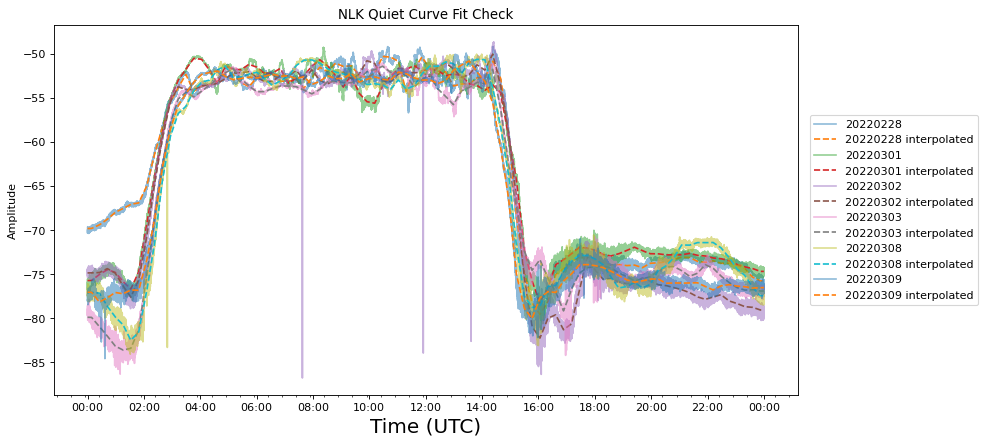

In [192]:
# NLK QDC with a peicewise method of multiple curve fits

bintime = 1000
# time_dt = np.zeros(len(time))
# time_dt[0] = dt.time(0,0,0)


pathcheck = 'NLK'
fig, ax1 = plt.subplots(figsize=(12,6),dpi=80)
for key in quietdict.keys():
    if key[:3] == pathcheck and quietdayflag[paths.index(key)] == 1:
        day = key[3:]
        print('Starting: '+str(day))
        time = quietdict[key]['time']
        amplitude = quietdict[key]['amplitude']

        time_dt = [dt.datetime(2022,3,1,0,0,0)+i*timedelta(seconds=1) for i in np.arange(len(time))]
        #plt.plot(time, amplitude, alpha=0.5, label=day)
        plt.plot(time_dt, amplitude, alpha=0.5, label=day)

        # curve fit with piecewise function
        print('Curvefitting....')
        popt, pcov = curve_fit(NLK_qdc, time, amplitude, p0=[4000,18000,45000,62000])
        print(popt)
        # plt.plot(time, NLK_qdc(time, *popt), '--',
        #  label='fit: br1= %5.3f, br2= %5.3f, br3= %5.3f, br4= %5.3f' % tuple(popt))
        
        # running average over the whole data set:
        bin_time, bin_amp = run_avg(time, amplitude, bintime)
        #plt.plot(bin_time, bin_amp, '-', label=day+' running avg')

        # interpolation func
        time_interp = np.linspace(time[0],time[-1],len(time))
        amp_interp = np.interp(time_interp, bin_time, bin_amp)

        #plt.plot(time_interp, amp_interp, '--', label=day+' interpolated')
        plt.plot(time_dt, amp_interp, '--', label=day+' interpolated')


#plt.plot(qdc_dict[pathcheck]['time'], qdc_dict[pathcheck]['amplitude'],'k', label=pathcheck+' avged quiet days')

#ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude') 
plt.title(pathcheck+' Quiet Curve Fit Check')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

ax1.set_xlabel('Time (UTC)',fontsize = 18)

time_locator = mdates.HourLocator(byhour=range(24),
                                interval = 2)
minor_time_locator = mdates.MinuteLocator(byminute=range(60),interval=30)
ax1.xaxis.set_minor_locator(minor_time_locator)
h_fmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_locator(time_locator)
ax1.xaxis.set_major_formatter(h_fmt)

# tick_spacing = 0.5e16
# ax2.yaxis.set_minor_locator(ticker.MultipleLocator(tick_spacing)) 
# ax2.tick_params(labelsize=12)


ax1.tick_params(axis='x', which='major', labelsize=10)


# stop


In [130]:
print(len(time), 60*60*24)
print(len(bin_amp),len(bin_time))
print(len(time)-len(bin_time))
print(86400/77760)
print(len(np.arange(1, len(bin_time), 10)), len(run_avg1d(bin_time,100)))

86396 86400
8640 8640
77756
1.1111111111111112
864
864
864 864


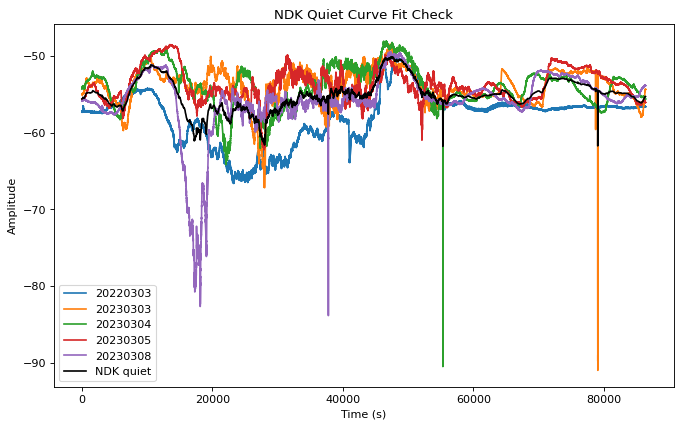

In [15]:
# check the fit of the quiet days
pathcheck = 'NDK'
plt.figure(figsize=(10,6),dpi=80)
for key in quietdict.keys():
    if key[:3] == pathcheck and quietdayflag[paths.index(key)] == 1:
        day = key[3:]
        time = quietdict[key]['time']
        amplitude = quietdict[key]['amplitude']
        plt.plot(time, amplitude, label=day)

plt.plot(qdc_dict[pathcheck]['time'], qdc_dict[pathcheck]['amplitude'],'k', label=pathcheck+' quiet')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude') 
plt.title(pathcheck+' Quiet Curve Fit Check')
plt.legend()



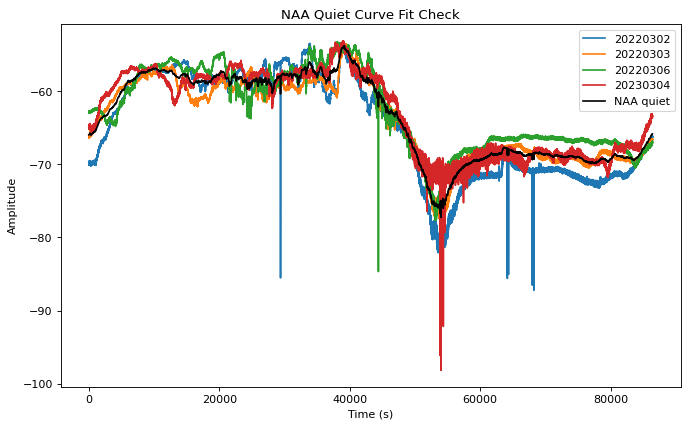

In [16]:
# check the fit of the quiet days
pathcheck = 'NAA'
plt.figure(figsize=(10,6),dpi=80)
for key in quietdict.keys():
    if key[:3] == pathcheck and quietdayflag[paths.index(key)] == 1:
        day = key[3:]
        time = quietdict[key]['time']
        amplitude = quietdict[key]['amplitude']
        plt.plot(time, amplitude, label=day)

plt.plot(qdc_dict[pathcheck]['time'], qdc_dict[pathcheck]['amplitude'],'k', label=pathcheck+' quiet')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude') 
plt.title(pathcheck+' Quiet Curve Fit Check')
plt.legend()

# 27 feb 2023

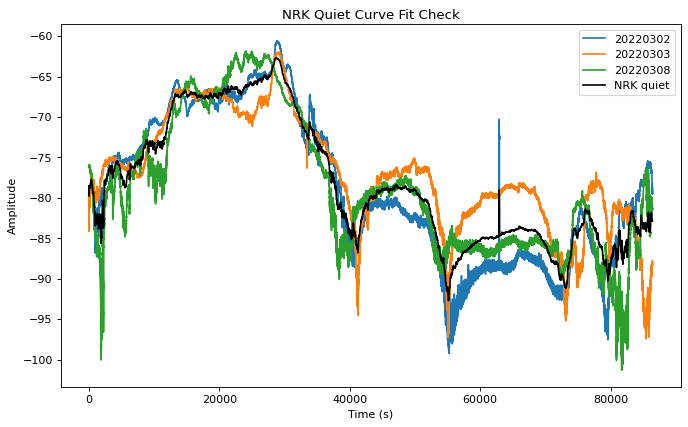

In [17]:
# check the fit of the quiet days
pathcheck = 'NRK'
plt.figure(figsize=(10,6),dpi=80)
for key in quietdict.keys():
    if key[:3] == pathcheck and quietdayflag[paths.index(key)] == 1:
        day = key[3:]
        time = quietdict[key]['time']
        amplitude = quietdict[key]['amplitude']
        plt.plot(time, amplitude, label=day)

plt.plot(qdc_dict[pathcheck]['time'], qdc_dict[pathcheck]['amplitude'],'k', label=pathcheck+' quiet')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude') 
plt.title(pathcheck+' Quiet Curve Fit Check')
plt.legend()



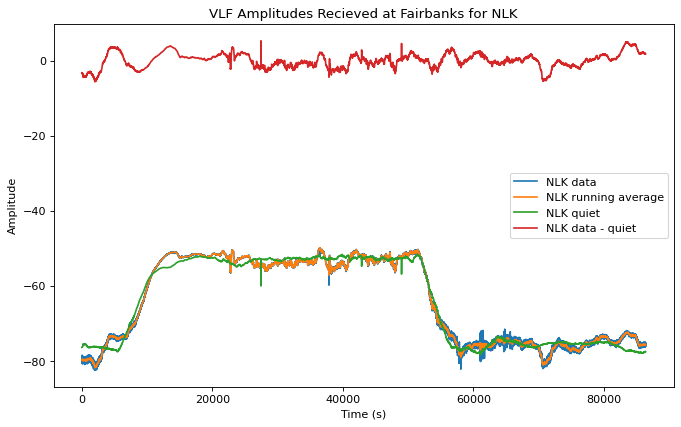

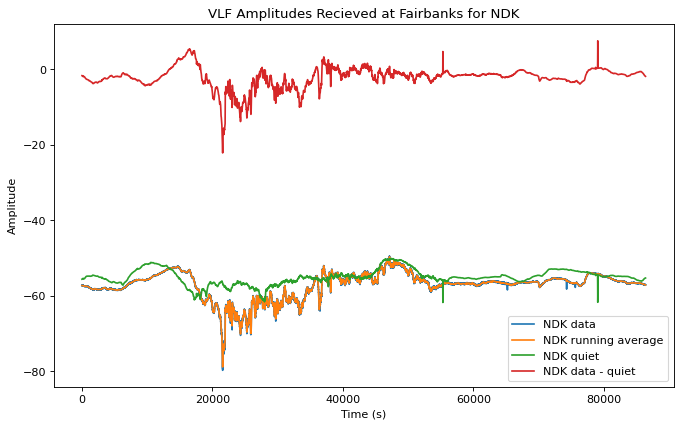

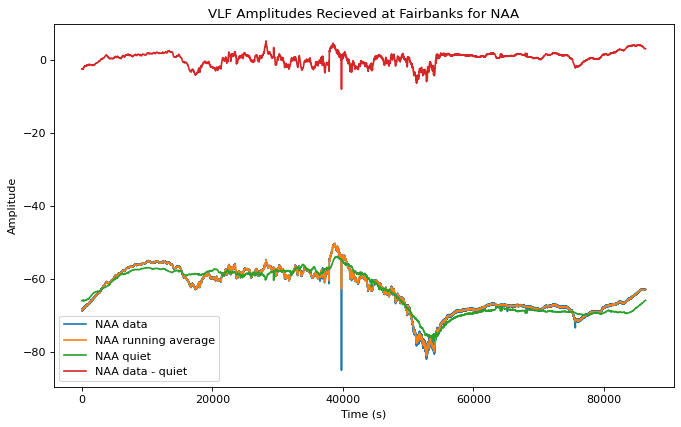

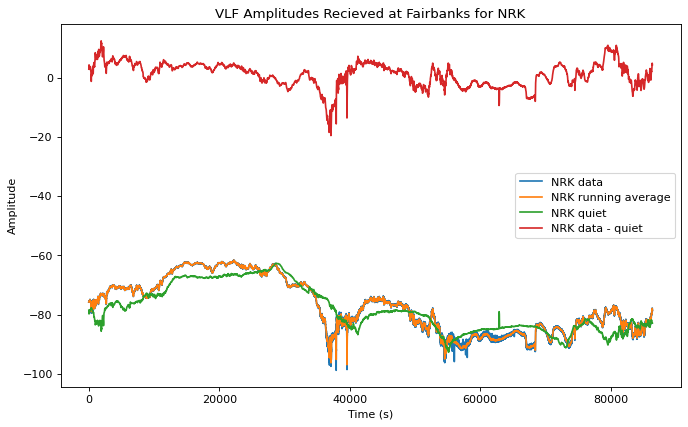

In [18]:
## Subtract off the averaged quiet days from data
# also need to do a running average of the data to sort out some noise and make the array the same size as the quiet day array

bintime = 15 #secs
for i,p in enumerate(pathnames):
    for datakey in datadict.keys():
        
        if p==datakey:
            plt.figure(figsize=(10,6),dpi=80)
            # data variables and plot
            datatime = datadict[datakey]['time']
            dataamp = datadict[datakey]['amplitude']
            plt.plot(datatime, dataamp, label=datakey+' data')

            # running average of the data:
            # set up the running average arrays
            binned_amp = []
            binned_time = []
            # set up runnign average values
            maxtime = datatime[-1]
            initialsec = datatime[0]
            multiples = int(round((maxtime-initialsec)/bintime)) # how many bins
            lenindex = len(time)
            indexblock = int(round(lenindex/multiples)) # how many indices in each bin
            # running average
            for m in np.arange(multiples):
                if m==0:
                    run_amp = np.average(dataamp[0:((m+1)*indexblock)])
                    run_time = np.average(datatime[0:(m+1)*indexblock])
                else:
                    run_amp = np.average(dataamp[m*indexblock:(m+1)*indexblock])
                    run_time = np.average(datatime[m*indexblock:(m+1)*indexblock])
                binned_amp.append(run_amp)
                binned_time.append(run_time)

            # plot the running average of data
            plt.plot(binned_time, binned_amp, label=datakey+' running average')

            # plot the quiet day average
            quiettime = qdc_dict[p]['time']
            quietamplitude = qdc_dict[p]['amplitude']
            plt.plot(quiettime, quietamplitude, label=p+' quiet')

            # subtract off the quiet day average
            data_sub = binned_amp - quietamplitude
            plt.plot(binned_time, data_sub, label=datakey+' data - quiet')

            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.title('VLF Amplitudes Recieved at Fairbanks for '+datakey)
            plt.legend()
